## Define problem

In [1]:
vmin=1364
vmax=6000 #thresholding 5990

h=25

nz=187; nx=801

dt=0.0025
nt=4000  #10 s

ntr=2000

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def read(filename,n=(nx,nz)):
    return np.fromfile(filename,dtype='float32').reshape(n).T

def read_su(filename,n=(ntr,nt)):
    data=read(filename,n=(n[0],int(60+n[1])))
    return data[60:,:]

def imshow(data,perc=None,clip=None,clipmin=None,extent=None,cmap='viridis',title=None,title_colorbar=None,grid=True):
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],cmap=cmap,extent=extent,aspect='auto')
    cbar=plt.colorbar(location='right')
    cbar=cbar.ax.set_ylabel(title_colorbar)
    if grid==True: plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

In [3]:
def make_FWDrun(app='FWD',np=28,nthreads=1,tag='',resdir='results',
                setup_more=[]):
    #!rm -fr $resdir
    exe='~/Codes/GitHub/SeisJIMU/exe/'+app
    #!rm run.slm; touch run.slm
    str=f"run_{tag}.sh"; print('bash '+str)
    #!cp /run/user/1001/gvfs/sftp:host=10.146.1.203,user=wei.zhou/cpgpfs/home/wei.zhou/run-compute.slm   $str
    !rm run_{tag}.sh
    ##
    #!sed -i 's/SBATCH --nodes=1/SBATCH --nodes=2/g' $str
    #!sed -i 's/#SBATCH --ntasks-per-node=28/#SBATCH --ntasks-per-node=14/g' $str
    ##
    with open(f"run_{tag}.sh", "a") as f:
        f.write(f"ulimit -s unlimited\n")
        f.write(f"export OMP_NUM_THREADS={nthreads}\n")
        f.write(f"mkdir -p {resdir} \n"),
        f.write(f"\n\n")
        ##
        f.write(f"cp setup_default setup_{tag}\n")
        f.write(f"echo \"DIR_OUT             \'{resdir}\'\"                     >> setup_{tag} \n")
        for i in range(len(setup_more)): f.write(f"echo \"{setup_more[i]}\"     >> setup_{tag} \n")
        f.write(f"mpirun --oversubscribe -np  {np}  {exe}  setup_{tag} > {resdir}/out \n")
        f.write(f"\n\n")

def make_FWIrun(app='FWI',np=28,nthreads=1,tag='',resdir='results',
                setup_more=[]):
    #!rm -fr $resdir
    exe='~/Codes/GitHub/SeisJIMU/exe/'+app
    #!rm run.slm; touch run.slm
    str=f"run_{tag}.sh"; print('bash '+str)
    #!cp /run/user/1001/gvfs/sftp:host=10.146.1.203,user=wei.zhou/cpgpfs/home/wei.zhou/run-compute.slm   $str
    !rm run_{tag}.sh
    ##
    #!sed -i 's/SBATCH --nodes=1/SBATCH --nodes=2/g' $str
    #!sed -i 's/#SBATCH --ntasks-per-node=28/#SBATCH --ntasks-per-node=14/g' $str
    ##
    with open(f"run_{tag}.sh", "a") as f:
        f.write(f"ulimit -s unlimited\n")
        f.write(f"export OMP_NUM_THREADS={nthreads}\n")
        f.write(f"mkdir -p {resdir} \n"),
        f.write(f"\n\n")
        ##
        f.write(f"cp setup_default setup_{tag}\n")
        f.write(f"echo \"DIR_OUT             \'{resdir}\'\"                     >> setup_{tag} \n")
        for i in range(len(setup_more)): f.write(f"echo \"{setup_more[i]}\"     >> setup_{tag} \n")
        f.write(f"mpirun --oversubscribe -np  {np}  {exe}  setup_{tag} > {resdir}/out \n")
        f.write(f"\n\n")

In [4]:
from scipy.ndimage import gaussian_filter


def imshow_overlay(data1,data2,alpha=0.6,data1perc=None,data2perc=None,data1clip=None,data2clip=None,
                   cmap1='seismic',cmap2='gray',
                   extent=None,title=None,grid=True):
    if data1perc==None:
        clipp1=[np.amin(data1),np.amax(data1)]
    else:
        tmp=np.percentile(np.abs(data1),q=data1perc)
        clipp1=[-tmp,tmp]
    if data2perc==None:
        clipp2=[np.amin(data2),np.amax(data2)]
    else:
        tmp=np.percentile(np.abs(data2),q=data2perc)
        clipp2=[-tmp,tmp]
    
    if data1clip!=None: clipp1=data1clip
    if data2clip!=None: clipp2=data2clip
        
    plt.imshow(data1,vmin=clipp1[0],vmax=clipp1[1],            cmap=cmap1,extent=extent,aspect='auto')
    plt.imshow(data2,vmin=clipp2[0],vmax=0        ,alpha=alpha,cmap=cmap2,extent=extent,aspect='auto')
    
    #plt.colorbar(location='right')
    if grid==True: plt.grid(visible=grid, axis='both', which='both', color='y', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def hilb_env(data):
    return np.abs(signal.hilbert(data,axis=0))

def normalize(data):
    out=np.zeros_like(data)
    amax=np.nanmax(data,axis=0)
    for i in range(amax.size):
        out[:,i]=data[:,i]/amax[i]
    return out
    
def amp_spec(data,axis=0):
    return np.abs(np.fft.rfft(data,axis=axis))

def smooth(data,sigma=(2,8)):
    return gaussian_filter(data,sigma=sigma)

def lat_avg(data):
    return np.mean(data,axis=1)

In [5]:
x=np.arange(0,nx)*h
z=np.arange(0,nz)*h

zpow=np.power(z,2)
zpow=np.tile(zpow,(nx,1)).T

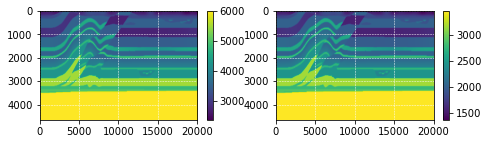

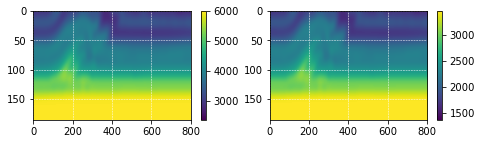

In [6]:
#plot
plt.figure(figsize=(12,2))
true=read('true',(3*nx,nz))
plt.subplot(1,3,1); imshow(true[:,:nx],clip=[2365,6000],extent=(0,(nx-1)*h,(nz-1)*h,0))
plt.subplot(1,3,2); imshow(true[:,nx:2*nx],clip=[1364,3462],extent=(0,(nx-1)*h,(nz-1)*h,0))

plt.figure(figsize=(12,2))
init=read('init',(3*nx,nz))
plt.subplot(1,3,1); imshow(init[:,:nx],clip=[2365,6000])
plt.subplot(1,3,2); imshow(init[:,nx:2*nx],clip=[1364,3462])

In [7]:
#!lda = rho(vp^2-2vs^2)
#!mu  = rho*vs^2
#!rho0= rho
#!gvp = glda*2rho*vp
#!gvs = (glda*-2 + gmu)*2rho*vs
#!grho= glda*vp^2 + (-2glda+gmu)*vs^2 + grho0
vp=init[:,:nx]
vs=init[:,nx:2*nx]
rho=1.
def chain(glda,gmu):
    gvp =  glda            *2*rho*vp
    gvs = (glda*(-2) + gmu)*2*rho*vs
    return (gvp, gvs) 

## Observed clean data

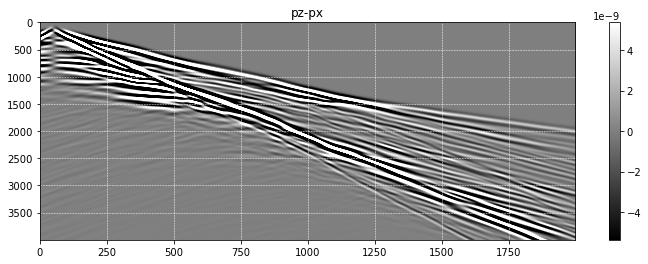

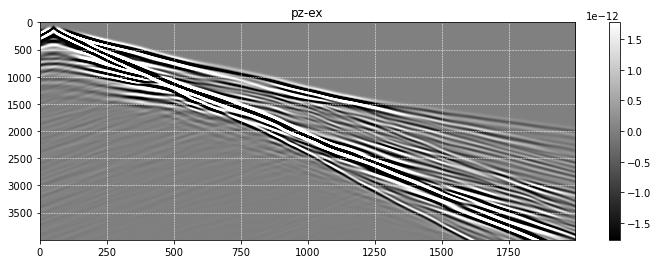

In [10]:
plt.figure(figsize=(12,4))
imshow(read_su('res_obs/px_Ru_Shot0001.su'),perc=90,title='pz-px',cmap='gray')

plt.figure(figsize=(12,4))
imshow(read_su('res_obs/ex_Ru_Shot0001.su'),perc=90,title='pz-ex',cmap='gray')

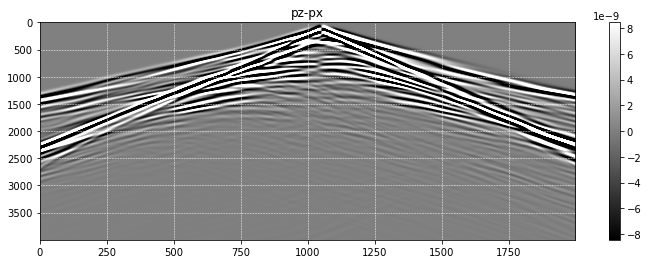

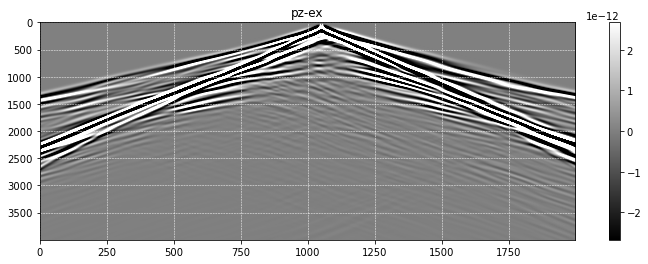

In [11]:
plt.figure(figsize=(12,4))
imshow(read_su('res_obs/px_Ru_Shot0021.su'),perc=90,title='pz-px',cmap='gray')

plt.figure(figsize=(12,4))
imshow(read_su('res_obs/ex_Ru_Shot0021.su'),perc=90,title='pz-ex',cmap='gray')

### convert ex to px in t-x domain

In [12]:
data=read_su('res_obs/ex_Ru_Shot0001.su')

dtr=10.
np.gradient(data,dtr,axis=1)
converted=-np.cumsum(data[:,::-1],axis=1)[:,::-1]*dtr
converted=np.gradient(converted,axis=0)/dt

ref=read_su('res_obs/px_Ru_Shot0001.su')

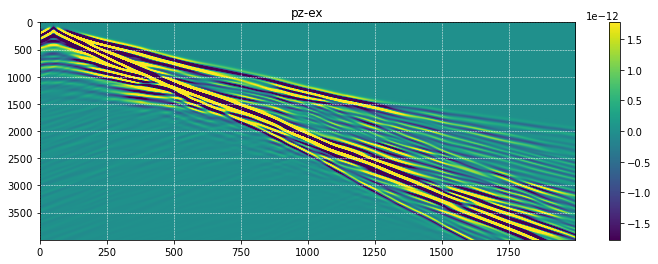

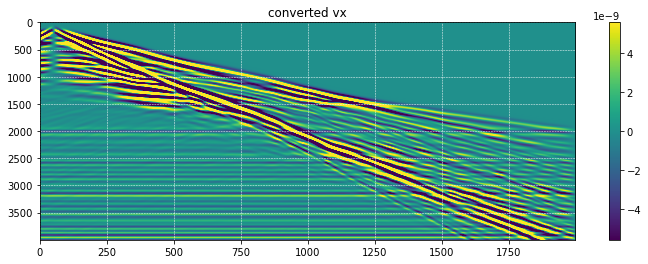

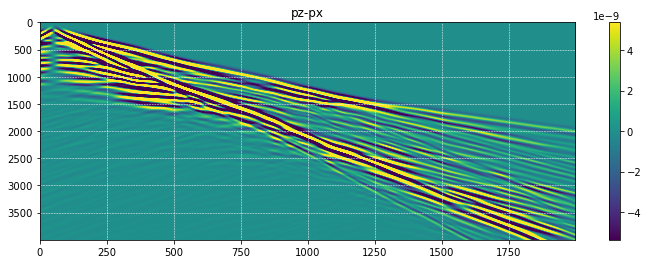

In [13]:
plt.figure(figsize=(12,4))
imshow(data,perc=90,title='pz-ex')

plt.figure(figsize=(12,4))
imshow(converted,perc=90,title='converted vx')

plt.figure(figsize=(12,4))
imshow(ref,perc=90,title='pz-px')

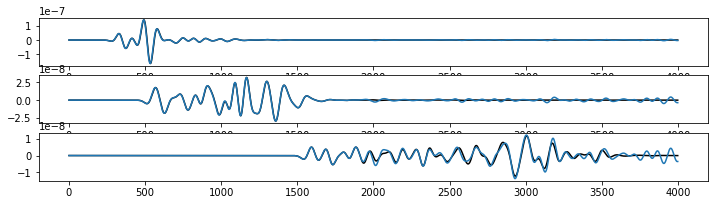

In [14]:
plt.figure(figsize=(12,3))
plt.subplot(3,1,1); itr=200
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,2); itr=400
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,3); itr=1400
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr])

In [16]:
data=read_su('res_obs/ex_Ru_Shot0021.su')

dtr=10.
np.gradient(data,dtr,axis=1)
converted=-np.cumsum(data[:,::-1],axis=1)[:,::-1]*dtr
converted=np.gradient(converted,axis=0)/dt

ref=read_su('res_obs/px_Ru_Shot0021.su')

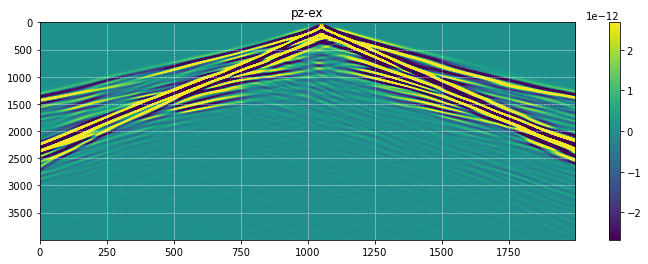

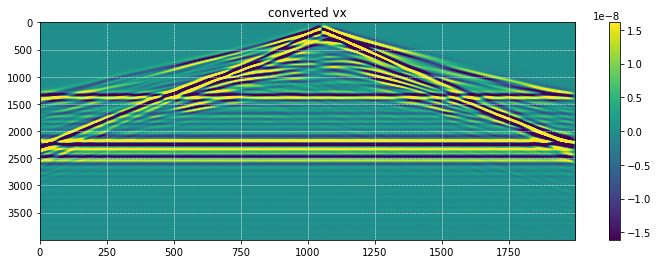

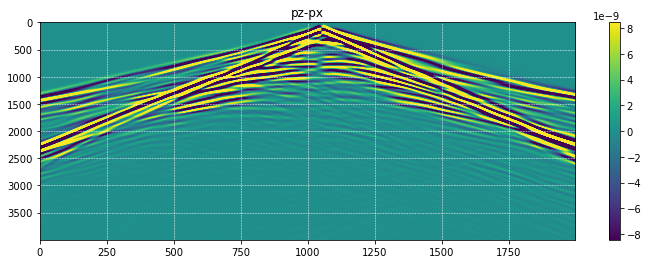

In [17]:
plt.figure(figsize=(12,4))
imshow(data,perc=90,title='pz-ex')

plt.figure(figsize=(12,4))
imshow(converted,perc=90,title='converted vx')

plt.figure(figsize=(12,4))
imshow(ref,perc=90,title='pz-px')

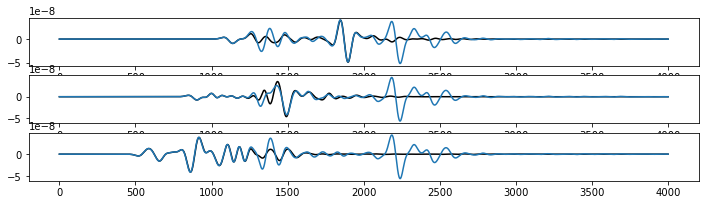

In [18]:
plt.figure(figsize=(12,3))
plt.subplot(3,1,1); itr=200
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,2); itr=400
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,3); itr=1400
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr])

### convert ex to px in f-k domain

In [19]:
#data=read_su('res_obs/ex_Ru_Shot0001.su')+1/SNR*read_su('noise.su')*scal

f=np.arange(0,nt//2+1)/(nt-1)/dt
f=np.concatenate((f[:nt//2],-f[nt//2+1:0:-1]))

dtr=10.
k=np.arange(0,ntr//2+1)/(ntr-1)/dtr
k=np.concatenate((k[:ntr//2],-k[ntr//2+1:0:-1]))

# print(f.shape,k.shape)

K,F = np.meshgrid(k,f)

# print(F)
# print(K)
# print(K*K)

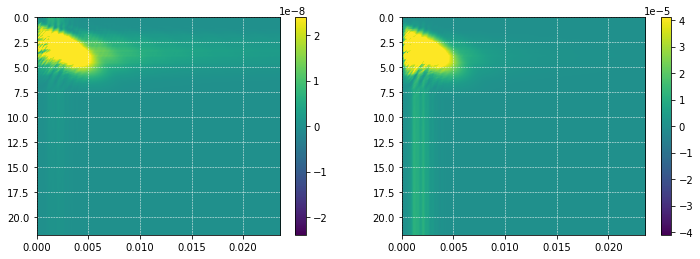

In [31]:
data=read_su('res_obs/ex_Ru_Shot0001.su')

spec=np.fft.fft2(data )

converted= spec*(F*K)/(K*K+np.max(K*K)*1e-4)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
imshow(np.abs(spec[:250,:nx//2]), perc=98 ,extent=(0,nx/2*0.000058858,250*0.087029854,0))

plt.subplot(1,2,2)
imshow(np.abs(converted[:250,:nx//2]), perc=98 ,extent=(0,nx/2*0.000058858,250*0.087029854,0))


converted=np.real(np.fft.ifft2(converted))

ref=read_su('res_obs/px_Ru_Shot0001.su')

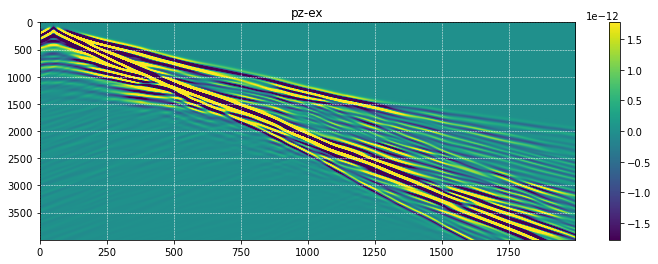

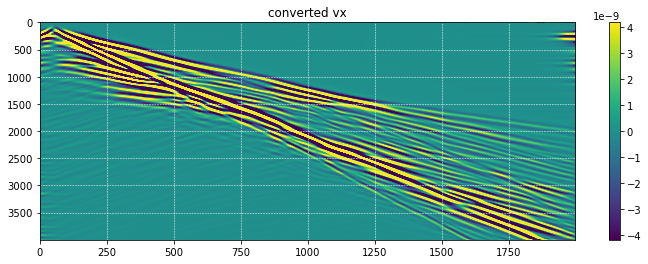

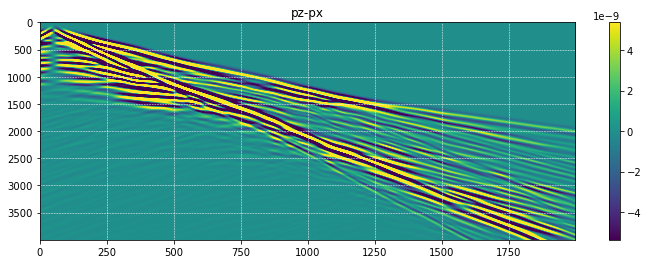

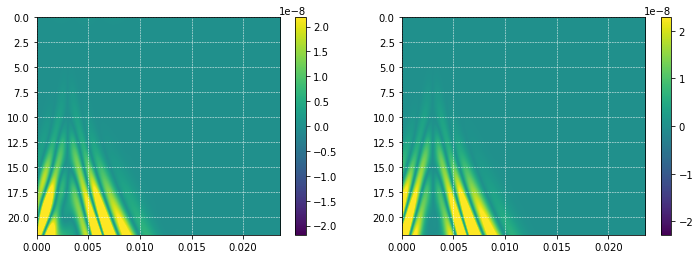

In [32]:
plt.figure(figsize=(12,4))
imshow(data,perc=90,title='pz-ex')

plt.figure(figsize=(12,4))
imshow(converted,perc=90,title='converted vx')

plt.figure(figsize=(12,4))
imshow(ref,perc=90,title='pz-px')

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
imshow(np.abs(converted[:250,:nx//2]), perc=98 ,extent=(0,nx/2*0.000058858,250*0.087029854,0))
plt.subplot(1,2,2)
imshow(np.abs(ref[:250,:nx//2]), perc=98 ,extent=(0,nx/2*0.000058858,250*0.087029854,0))

(-3e-08, 3e-08)

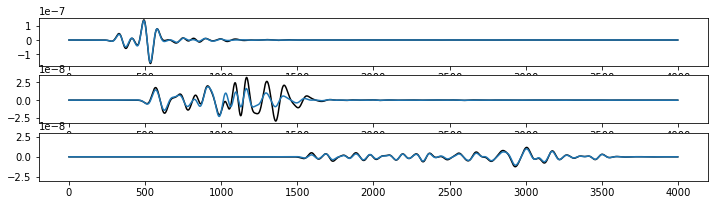

In [33]:
plt.figure(figsize=(12,3))
plt.subplot(3,1,1); itr=200
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,2); itr=400
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,3); itr=1400
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr]); plt.ylim((-3e-8,3e-8))

## Observed noisy data

In [8]:
SNR=20

### gen noise

In [9]:
#dt=0.0025
!makevel nx=$ntr nz=$nt v000=0 | suaddhead ns=$nt | sushw key=dt a=2500 > tmp.su

!suaddnoise < tmp.su | sufilter f=0,1,4,8 amps=0,1,1,0 > noise.su
#!suaddnoise < tmp.su | sufilter f=6,10 amps=1,0 > noise.su

!sustack < noise.su key=trid repeat=1 nrepeat=$ntr > tmp.su
!sudiff noise.su tmp.su > noise1.su ; mv noise1.su noise.su

#np.gradient(np.gradient(read_su('noise.su'),axis=0),axis=1).T.astype('float32').tofile('noise')
#!suaddhead < noise ns=$nt | sushw key=dt a=1690 > noise.su

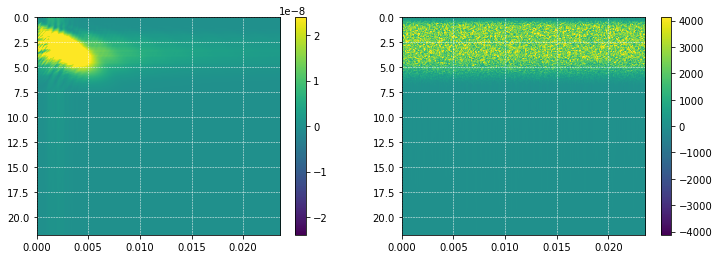

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
imshow(np.abs(np.fft.rfft2(read_su('res_obs/ex_Ru_Shot0001.su'))[:250,:nx//2]), perc=98 ,extent=(0,nx/2*0.000058858,250*0.087029854,0))

plt.subplot(1,2,2)
imshow(np.abs(np.fft.rfft2(read_su('noise.su'))[:250,:nx//2]), perc=98 ,extent=(0,nx/2*0.000058858,250*0.087029854,0))

# plt.subplot(1,2,1)
# imshow(amp_spec(read_su('res_obs/ex_Ru_Shot0001.su'))[:250,:],perc=98,extent=(0,1500,250*0.087029854,0))

# plt.subplot(1,2,2)
# imshow(amp_spec(read_su('noise.su'))[:250,:],perc=98,extent=(0,1500,250*0.087017055,0))

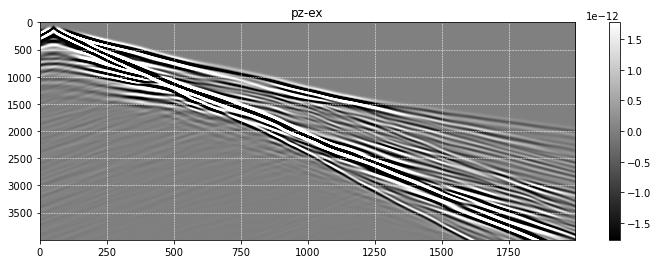

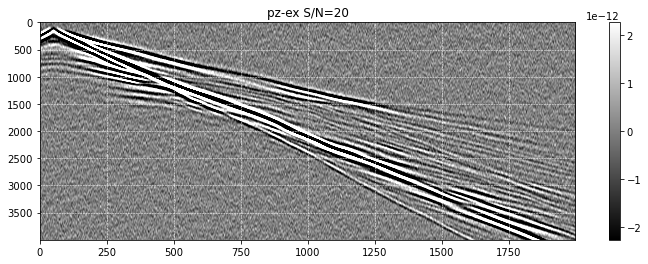

In [11]:
plt.figure(figsize=(12,4))
imshow(read_su('res_obs/ex_Ru_Shot0001.su'),perc=90,title='pz-ex',cmap='gray')

norm_signal=  np.max(np.abs(read_su('res_obs/ex_Ru_Shot0001.su')))
norm_noise =  np.max(np.abs(read_su('noise.su')) )
scal=norm_signal/norm_noise

plt.figure(figsize=(12,4))
imshow(read_su('res_obs/ex_Ru_Shot0001.su')+1/SNR*read_su('noise.su')*scal,perc=90,title=f'pz-ex S/N={SNR}',cmap='gray')

### convert ex to px in t-x domain

In [12]:
data=read_su('res_obs/ex_Ru_Shot0001.su')+1/SNR*read_su('noise.su')*scal

dtr=10.
np.gradient(data,dtr,axis=1)
converted=-np.cumsum(data[:,::-1],axis=1)[:,::-1]*dtr
converted=np.gradient(converted,axis=0)/dt
# converted=-data


norm_signal=  np.max(np.abs(read_su('res_obs/px_Ru_Shot0001.su')))
norm_noise =  np.max(np.abs(read_su('noise.su')) )
scal=norm_signal/norm_noise

ref=read_su('res_obs/px_Ru_Shot0001.su')#+1/20*read_su('noise.su')*scal

#converted=converted*np.sum(np.abs(ref))/np.sum(np.abs(converted))

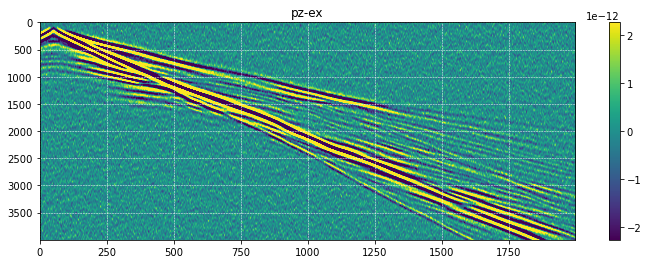

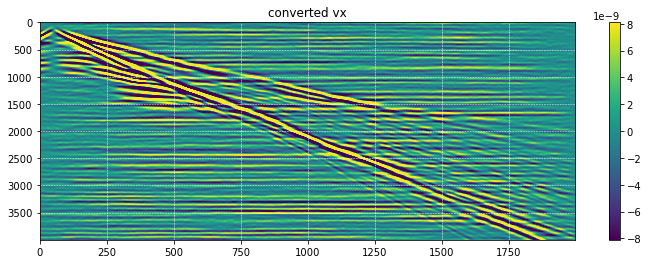

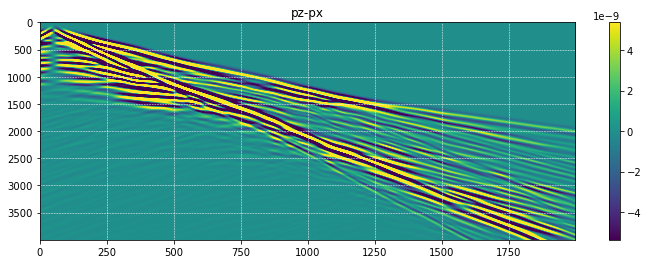

In [13]:
plt.figure(figsize=(12,4))
imshow(data,perc=90,title='pz-ex')

plt.figure(figsize=(12,4))
imshow(converted,perc=90,title='converted vx')

plt.figure(figsize=(12,4))
imshow(ref,perc=90,title='pz-px')

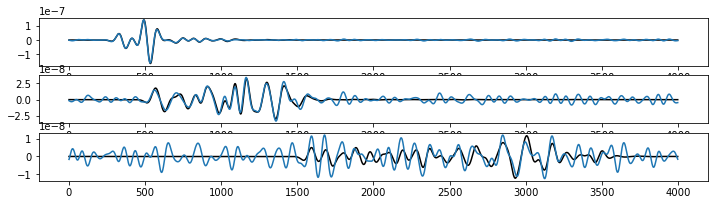

In [14]:
plt.figure(figsize=(12,3))
plt.subplot(3,1,1); itr=200
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,2); itr=400
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,3); itr=1400
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr])

### convert ex to px in f-k domain

In [15]:
#data=read_su('res_obs/ex_Ru_Shot0001.su')+1/SNR*read_su('noise.su')*scal

f=np.arange(0,nt//2+1)/(nt-1)/dt
f=np.concatenate((f[:nt//2],-f[nt//2+1:0:-1]))

dtr=10.
k=np.arange(0,ntr//2+1)/(ntr-1)/dtr
k=np.concatenate((k[:ntr//2],-k[ntr//2+1:0:-1]))

# print(f.shape,k.shape)

K,F = np.meshgrid(k,f)

# print(F)
# print(K)
# print(K*K)

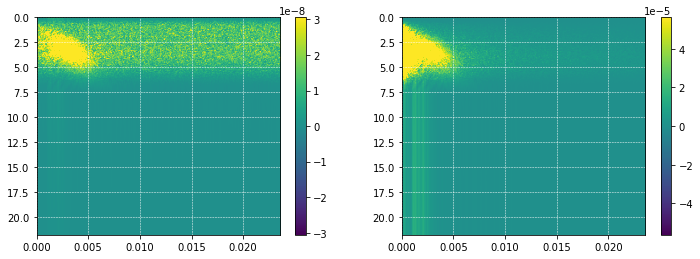

In [16]:
norm_signal=  np.max(np.abs(read_su('res_obs/ex_Ru_Shot0001.su')))
norm_noise =  np.max(np.abs(read_su('noise.su')) )
scal=norm_signal/norm_noise

data=read_su('res_obs/ex_Ru_Shot0001.su')+1/SNR*read_su('noise.su')*scal

spec=np.fft.fft2(data )

converted= spec*(F*K)/(K*K+np.max(K*K)*1e-5)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
imshow(np.abs(spec[:250,:nx//2]), perc=98 ,extent=(0,nx/2*0.000058858,250*0.087029854,0))

plt.subplot(1,2,2)
imshow(np.abs(converted[:250,:nx//2]), perc=98 ,extent=(0,nx/2*0.000058858,250*0.087029854,0))


converted=np.real(np.fft.ifft2(converted))


# norm_signal=  np.max(np.abs(read_su('res_obs/px_Ru_Shot0001.su')))
# norm_noise =  np.max(np.abs(read_su('noise.su')) )
# scal=norm_signal/norm_noise

ref=read_su('res_obs/px_Ru_Shot0001.su')#+SNR*read_su('noise.su')*scal

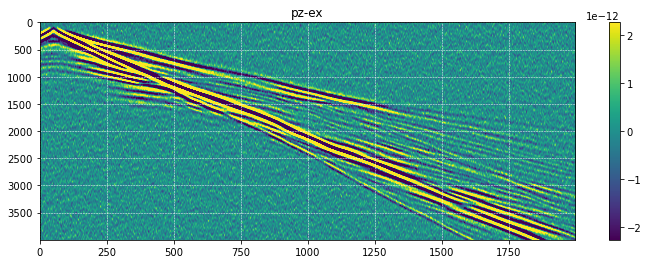

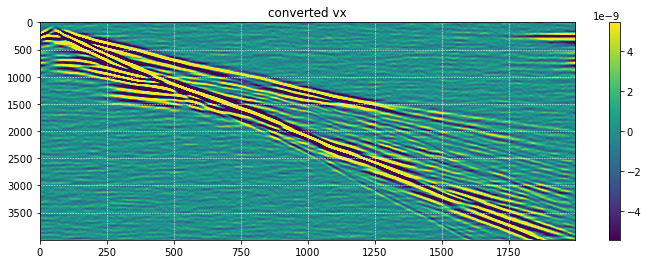

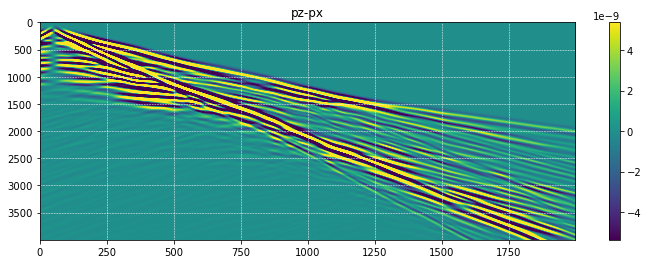

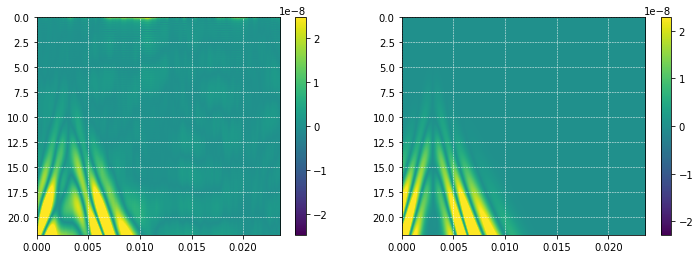

In [17]:
plt.figure(figsize=(12,4))
imshow(data,perc=90,title='pz-ex')

plt.figure(figsize=(12,4))
imshow(converted,perc=90,title='converted vx')

plt.figure(figsize=(12,4))
imshow(ref,perc=90,title='pz-px')

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
imshow(np.abs(converted[:250,:nx//2]), perc=98 ,extent=(0,nx/2*0.000058858,250*0.087029854,0))
plt.subplot(1,2,2)
imshow(np.abs(ref[:250,:nx//2]), perc=98 ,extent=(0,nx/2*0.000058858,250*0.087029854,0))

(-3e-08, 3e-08)

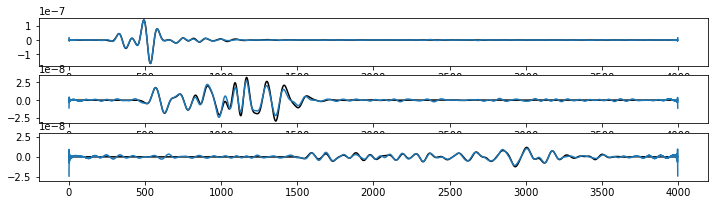

In [18]:
plt.figure(figsize=(12,3))
plt.subplot(3,1,1); itr=200
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,2); itr=400
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,3); itr=1400
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr]); plt.ylim((-3e-8,3e-8))

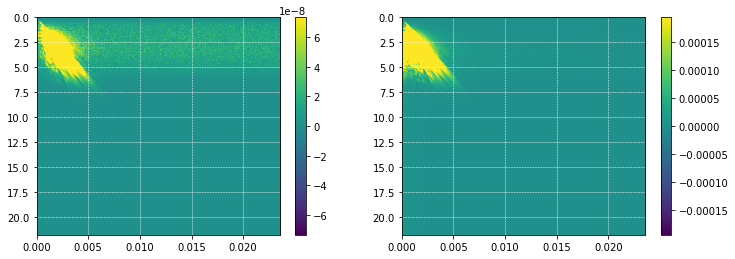

In [19]:
norm_signal=  np.max(np.abs(read_su('res_obs/ex_Ru_Shot0021.su')))
norm_noise =  np.max(np.abs(read_su('noise.su')) )
scal=norm_signal/norm_noise

data=read_su('res_obs/ex_Ru_Shot0021.su')+1/SNR*read_su('noise.su')*scal

spec=np.fft.fft2(data )

converted= spec*(F*K)/(K*K+np.max(K*K)*1e-5)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
imshow(np.abs(spec[:250,:nx//2]), perc=98 ,extent=(0,nx/2*0.000058858,250*0.087029854,0))

plt.subplot(1,2,2)
imshow(np.abs(converted[:250,:nx//2]), perc=98 ,extent=(0,nx/2*0.000058858,250*0.087029854,0))


converted=np.real(np.fft.ifft2(converted))


# norm_signal=  np.max(np.abs(read_su('res_obs/px_Ru_Shot0002.su')))
# norm_noise =  np.max(np.abs(read_su('noise.su')) )
# scal=norm_signal/norm_noise

ref=read_su('res_obs/px_Ru_Shot0021.su')#+1/20*read_su('noise.su')*scal

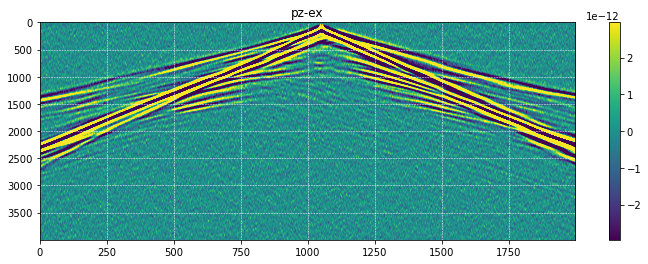

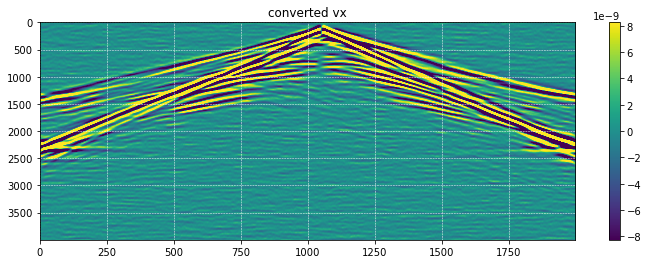

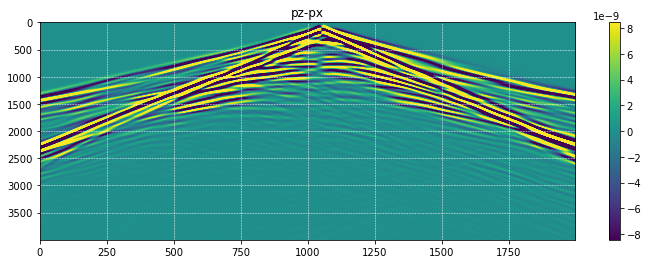

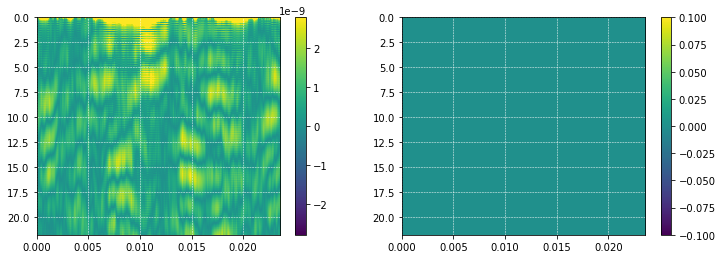

In [20]:
plt.figure(figsize=(12,4))
imshow(data,perc=90,title='pz-ex')

plt.figure(figsize=(12,4))
imshow(converted,perc=90,title='converted vx')

plt.figure(figsize=(12,4))
imshow(ref,perc=90,title='pz-px')

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
imshow(np.abs(converted[:250,:nx//2]), perc=98 ,extent=(0,nx/2*0.000058858,250*0.087029854,0))
plt.subplot(1,2,2)
imshow(np.abs(ref[:250,:nx//2]), perc=98 ,extent=(0,nx/2*0.000058858,250*0.087029854,0))

(-3e-08, 3e-08)

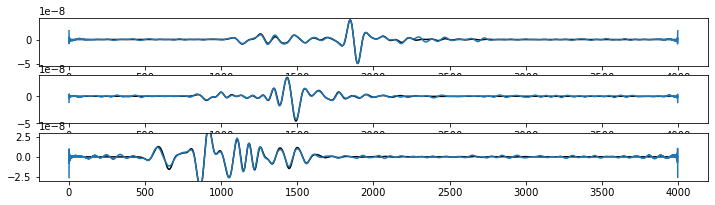

In [21]:
plt.figure(figsize=(12,3))
plt.subplot(3,1,1); itr=200
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,2); itr=400
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,3); itr=1400
plt.plot(ref[:,itr],'k'); plt.plot(converted[:,itr]); plt.ylim((-3e-8,3e-8))

## Generate the noisy data for FWI

In [22]:
!makevel nx=$ntr nz=$nt v000=0 | suaddhead ns=$nt | sushw key=dt a=2500 > tmp.su

!suaddnoise < tmp.su | sufilter f=0,1,4,8 amps=0,1,1,0 > noise.su

!sustack < noise.su key=trid repeat=1 nrepeat=$ntr > tmp.su
!sudiff noise.su tmp.su > noise1.su ; mv noise1.su noise.su

In [23]:
SNR=20

In [24]:
comp='ex'
norm_signal=  np.max(np.abs(read_su(f'res_obs/{comp}_Ru_Shot0001.su')))
norm_noise =  np.max(np.abs(read_su('noise.su')) )
scal=norm_signal/norm_noise /SNR

!sustrip < noise.su | farith op=scale scale=$scal | suaddhead ns=$nt | sushw key=dt a=2500 > tmp.su

for i in range(1,40):
    str=f'susum res_obs/{comp}_Ru_Shot{i:04d}.su tmp.su > res_obs_corrupted/{comp}_Ru_Shot{i:04d}.su'
    !$str

n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000


In [ ]:
comp='px'
norm_signal=  np.max(np.abs(read_su(f'res_obs/{comp}_Ru_Shot0001.su')))
norm_noise =  np.max(np.abs(read_su('noise.su')) )
scal=norm_signal/norm_noise /SNR

!sustrip < noise.su | farith op=scale scale=$scal | suaddhead ns=$nt | sushw key=dt a=2500 > tmp.su

for i in range(1,40):
    str=f'susum res_obs/{comp}_Ru_Shot{i:04d}.su tmp.su > res_obs_corrupted/{comp}_Ru_Shot{i:04d}.su'
    !$str

In [ ]:
f=np.arange(0,nt//2+1)/(nt-1)/dt
f=np.concatenate((f[:nt//2],-f[nt//2+1:0:-1]))

dtr=10.
k=np.arange(0,ntr//2+1)/(ntr-1)/dtr
k=np.concatenate((k[:ntr//2],-k[ntr//2+1:0:-1]))

K,F = np.meshgrid(k,f)

In [25]:
for i in range(1,40):
    data=read_su(f'res_obs_corrupted/ex_Ru_Shot{i:04d}.su')
    spec=np.fft.fft2(data )
    converted= spec*(F*K)/(K*K+np.max(K*K)*1e-5)
    converted=np.real(np.fft.ifft2(converted))
    converted.T.astype('float32').tofile('tmp')
    str=f'sustrip < res_obs_corrupted/ex_Ru_Shot{i:04d}.su head=head > tmp1'
    !$str
    str=f'supaste < tmp ns={nt} head=head | sushw key=trid a=34 > res_obs_corrupted/convtd_px_Ru_Shot{i:04d}.su'
    !$str

!rm tmp tmp1

n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000
n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000
n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000
n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000
n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000
n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000
n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000
n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000
n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000
n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000
n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000
n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000
n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000
n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000
n1=4000 n2=2000 d1=0.002500
nt=4000 ntr=2000 dt=0.002500
ns=4000
n1=4000 n2=2000 d1=0.0025

(-3e-08, 3e-08)

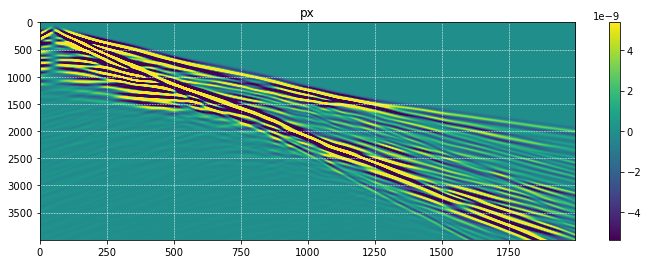

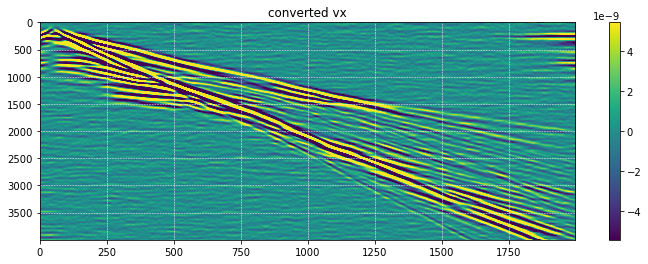

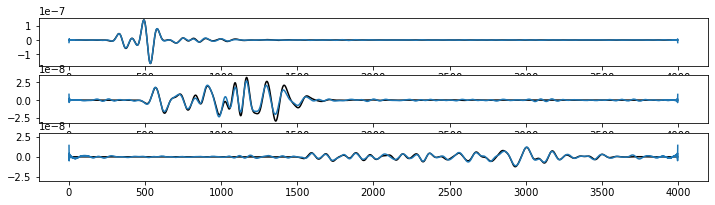

In [26]:
plt.figure(figsize=(12,4))
data=read_su(f'res_obs/px_Ru_Shot0001.su')
imshow(data,perc=90,title='px')

converted=read_su(f'res_obs_corrupted/convtd_px_Ru_Shot0001.su')
plt.figure(figsize=(12,4))
imshow(converted,perc=90,title='converted vx')

plt.figure(figsize=(12,3))
plt.subplot(3,1,1); itr=200
plt.plot(data[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,2); itr=400
plt.plot(data[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,3); itr=1400
plt.plot(data[:,itr],'k'); plt.plot(converted[:,itr]); plt.ylim((-3e-8,3e-8))

13


(-3e-08, 3e-08)

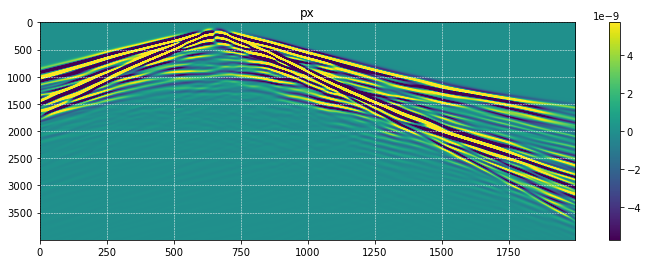

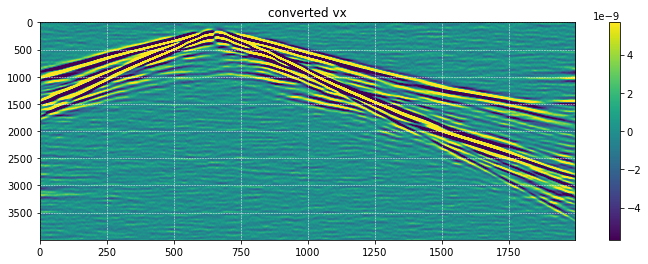

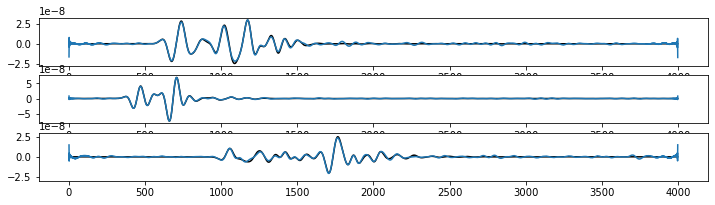

In [27]:
i=np.random.randint(1,40)
print(i)

plt.figure(figsize=(12,4))
data=read_su(f'res_obs/px_Ru_Shot{i:04d}.su')
imshow(data,perc=90,title='px')

converted=read_su(f'res_obs_corrupted/convtd_px_Ru_Shot{i:04d}.su')
plt.figure(figsize=(12,4))
imshow(converted,perc=90,title='converted vx')

plt.figure(figsize=(12,3))
plt.subplot(3,1,1); itr=200
plt.plot(data[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,2); itr=400
plt.plot(data[:,itr],'k'); plt.plot(converted[:,itr])
plt.subplot(3,1,3); itr=1400
plt.plot(data[:,itr],'k'); plt.plot(converted[:,itr]); plt.ylim((-3e-8,3e-8))